### Simulator calibration

Code for fidgeting with simulator to get it near T5 dataset characteristics


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import hmmdecode_vonmises, hmmviterbi_vonmises
from hmm_utils import *
from simulation import * 
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)
fig_path       = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'

#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [2]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = generateUnits(n_units = nUnits, SNR = SNR)
calNeural, calVelocity = simulateUnitActivity(initialTuning, noise= 0.3, nSteps= nTrainingSteps)


lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

0 / 10


../utils\simulation\simulation.py:143: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = neuralTuning[:,1:].dot(currControl)
../utils\simulation\simulation.py:148: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = np.dot(D[1:,:].T, simAct)


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


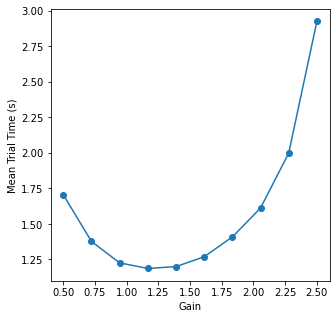

In [3]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [4]:
# general settings:

nSimSteps    = 100000
n_sessions   = 5
days_between = 0


posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)

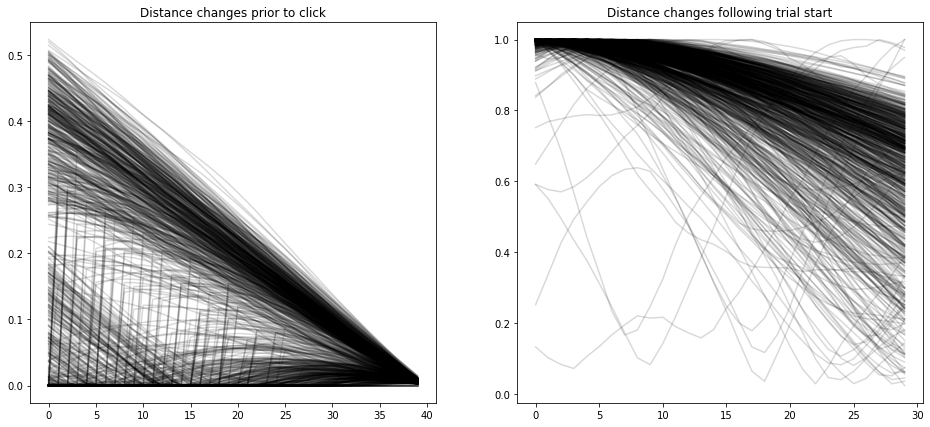

In [5]:
figSize(7, 16)

lookback   = 40
nHoldSteps = 50

plt.subplot(1, 2, 1)
plt.title('Distance changes prior to click')
for t in trialStart:
    dist  = np.linalg.norm(posTraj[(t - nHoldSteps - lookback):(t - nHoldSteps), :] - targTraj[(t - nHoldSteps - lookback):(t - nHoldSteps), :], axis = 1)
    dist  = np.maximum(dist - 0.0725, 0)
    plt.plot(dist, color = 'k', alpha = 0.15)
    
    
plt.subplot(1, 2, 2)
plt.title('Distance changes following trial start')
for i, t in enumerate(trialStart):
    dist  = np.linalg.norm(posTraj[t:(t + 30), :] - targTraj[t:(t + 30), :], axis = 1)
    dist /= dist.max()
    plt.plot(dist, color = 'k', alpha = 0.15)

In [73]:
from metrics import estimateSNR
figSize(7, 7)

# Setup settings:
nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000
alpha          = 0.90   # amount of exponential smoothing (0.9 to 0.96 are reasonable)
beta           = 1.1666 # use standard optimal beta for this alpha value 
delT           = 0.01   # define the time step (10 ms)
nDelaySteps    = 20     # define the simulated user's visual feedback delay (200 ms)

# SNR calc settings:
nSimSteps       = 10000
nReps           = 100
thresh          = 0.3   # only calculate SNR using points far from target
cutStart        = 7     # exclude first <cutStart> timesteps

SNRvals = np.zeros((nReps,))
corrs   = np.zeros((nReps,))

for n in range(nReps):
    initialTuning          = generateUnits(n_units = nUnits, SNR = SNR)
    calNeural, calVelocity = simulateUnitActivity(initialTuning, noise= 0.3, nSteps= nTrainingSteps)
    lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)
    
    SNRvals[n], usedIdx = estimateSNR(neuralTraj, posTraj, targTraj, trialStart, thresh, cutStart)
    #corrs[n]            = LinearRegression().fit(neuralTraj[:8000, :], (targTraj - posTraj)[:8000, :]).score(neuralTraj[8000:, :], (targTraj - posTraj)[8000:, :])
    corrs[n] = np.mean(ttt)
    if ( n + 1) % 10 == 0:
        print(n + 1, '/', nReps, ' complete.')

10 / 100  complete.
20 / 100  complete.
30 / 100  complete.
40 / 100  complete.
50 / 100  complete.
60 / 100  complete.
70 / 100  complete.
80 / 100  complete.
90 / 100  complete.
100 / 100  complete.


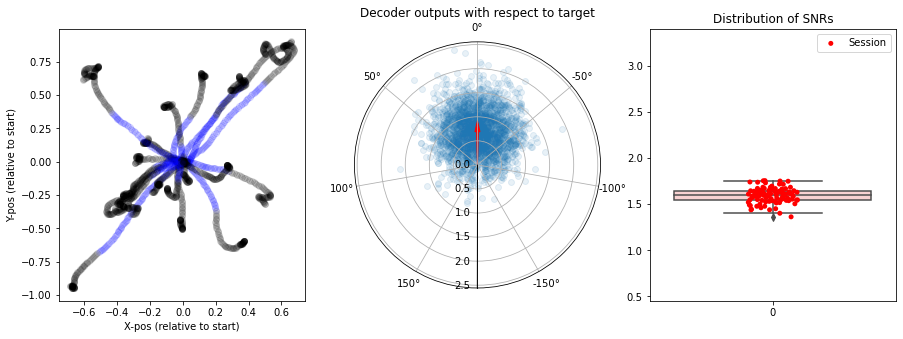

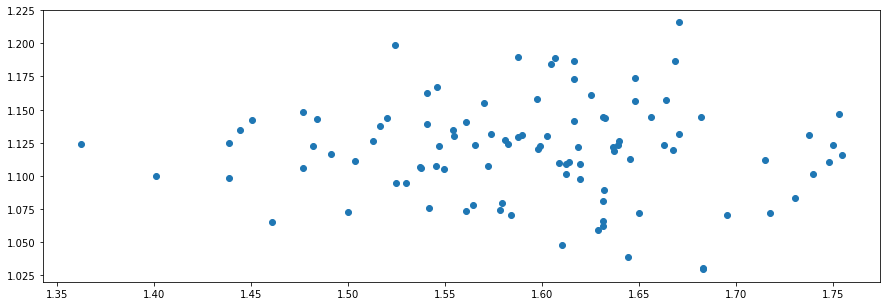

In [74]:
import seaborn as sns
from CosineTuning import getAngles
from plotting_utils import modifyBoxPlotAlpha

figSize(5, 15)

# example trials with delineated timepoints used in SNR calculation:
plt.subplot(1, 3, 1)
for i in range( 20):
    start = int(trialStart[i])
    stop  = int(trialStart[i+1] - 1)

    trlTraj          = posTraj[start:stop, :] 
    trlTraj_centered = trlTraj - posTraj[start, :]
    
    used   = np.in1d(np.arange(start, stop), usedIdx) 
    unused = ~ used

    _ = plt.scatter(trlTraj_centered[used, 0], trlTraj_centered[used, 1], color = 'b', alpha = 0.1)
    _ = plt.scatter(trlTraj_centered[unused, 0], trlTraj_centered[unused, 1], color = 'k', alpha = 0.1)

    plt.xlabel('X-pos (relative to start)')
    plt.ylabel('Y-pos (relative to start)')

# decoder and point-at-target vector angles, with SNR modeling:
plt.subplot(132, projection = 'polar')
cursorErr = targTraj - posTraj
dists     = np.linalg.norm(cursorErr[usedIdx, :], axis = 1)
p_t       = cursorErr[usedIdx, :] / dists[:, np.newaxis]  # unit vector pointing at target
u_t       = lr.predict(neuralTraj[usedIdx, :])  
mult      = np.linalg.lstsq(p_t, u_t, rcond = None)[0][0][0]
res       = u_t - (p_t * mult)
SNR       = mult / np.std(res)
angles    = getAngles(u_t, p_t) * np.sign(np.cross(p_t, u_t)) # get absolute angle deviation not inner angle
magn      = np.linalg.norm(u_t, axis = 1)

plt.scatter(angles, magn, alpha = 0.1)
plt.arrow(0, 0, 0, mult, color = 'r', width=0.05, alpha  = 1)
ax = plt.gca()
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(179.9)
plt.title('Decoder outputs with respect to target')

# distribution of SNRs across randomly initialized instances of simulator:
plt.subplot(1, 3, 3)
plt.title('Distribution of SNRs')
sns.boxplot(data = SNRvals, orient = 'v', color = 'r')
ax = plt.gca()
modifyBoxPlotAlpha(ax, 0.2)
sns.stripplot(data = SNRvals, orient = 'v', color = 'r', label = 'Session', jitter = 0.1)
plt.ylim((0.45198856864575165, 3.3982495442853766))
plt.legend()

plt.savefig(fig_path + 'SNR/simulator_exampleAndAllSNRs', format = 'pdf')

plt.figure()
plt.scatter(SNRvals, corrs)

both R$^{2}$ and SNR seem to be in T5 range (median T5 SNR = 1.5,  R$^{2}$ usually in 0.3 area). Now let's see how our subspace shift dynamics match up to that of T5 as determined by cos(theta).


In [75]:
from joblib import Parallel, delayed

# general settings:
nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000
n_repeats      = 100
tuning_shift   = [0.92, 1, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
renormalize    = True
max_stretch    = 14   # simulate n_repeats random chains of nonstationarities out this many days

#-----------------------------------------
cos_angles = np.zeros((max_stretch, n_repeats, 2, )) 


initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)
tuning         = [np.copy(initialTuning) for j in range(n_repeats)]
initEnc        = np.copy(initialTuning[:, 1:])
initEnc       /= np.linalg.norm(initEnc, axis = 0)
for i in range(max_stretch):
    tuning = [simulateTuningShift(tuning[j], PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], mean_shift = tuning_shift[2], renormalize = renormalize) for j in range(n_repeats)]
    
    for j, newTuning in enumerate(tuning):
        enc                 = newTuning[:, 1:] 
        enc /= np.linalg.norm(enc, axis = 0)
        
        cos_angles[i, j, :] = np.diag(enc.T.dot(initEnc))

    print('Day ', i + 1, ' finished.')
   # print(np.linalg.norm(newTuning[:, 1:], axis = 0))


diffs      = np.concatenate([i * np.ones((n_repeats)) for i in range(1, max_stretch + 1)])
cos_angles = cos_angles.reshape(n_repeats*max_stretch, 2,)

Day  1  finished.
Day  2  finished.
Day  3  finished.
Day  4  finished.
Day  5  finished.
Day  6  finished.
Day  7  finished.
Day  8  finished.
Day  9  finished.
Day  10  finished.
Day  11  finished.
Day  12  finished.
Day  13  finished.
Day  14  finished.


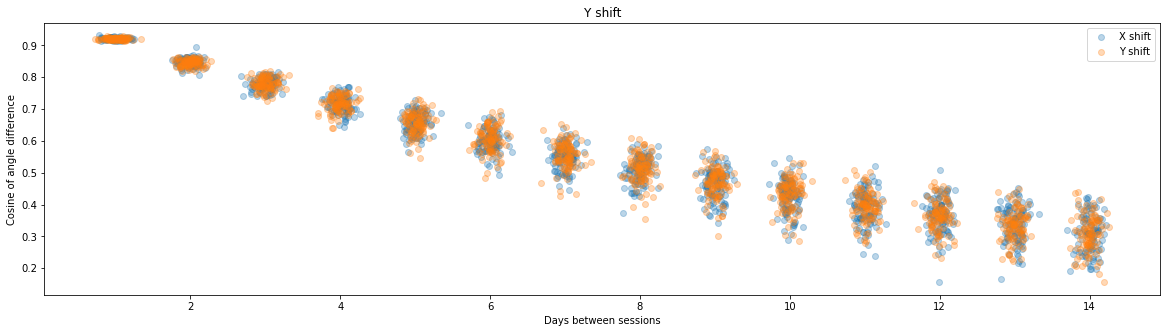

In [89]:
figSize(5, 20)

labels = ['X shift', 'Y shift']
for i, label in enumerate(labels):
  #  plt.subplot(2, 2, i + 1)
    plt.scatter(diffs + np.random.normal(loc = 0, scale = 0.1, size = cos_angles.shape[0]), cos_angles[:, i], alpha = 0.3, label = label)
    plt.title(label)
    plt.xlabel('Days between sessions')
    plt.ylabel('Cosine of angle difference')
    plt.legend()
    
